In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import OneCycleLR

# Dinh nghia cac class
classes = ['Aorta', 'Flows', 'Other', 'V sign', 'X sign']

class FetalEchoDataset(Dataset):
    def __init__(self, root_dir, phase='train', transform=None, selected_classes=None, x_sign_mode='both'):
        self.root_dir = root_dir
        self.phase = phase
        self.transform = transform

        all_classes = ['Aorta', 'Flows', 'Other', 'V sign', 'X sign']
        self.classes = selected_classes if selected_classes is not None else all_classes
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.samples = []

        # Kiem tra thu muc phase co ton tai khong
        phase_path = os.path.join(root_dir, phase)
        if not os.path.exists(phase_path):
            print(f"CANH BAO: Khong tim thay thu muc {phase_path}")
            return

        if phase in ['train']:
            for cls in self.classes:
                if cls == 'X sign':
                    if x_sign_mode == 'clear':
                        subfolder = 'X sign/clear'
                        folder_path = os.path.join(root_dir, phase, subfolder)
                        if os.path.exists(folder_path):
                            for fname in os.listdir(folder_path):
                                if fname.endswith(('.jpg', '.png', '.jpeg')):
                                    full_path = os.path.join(folder_path, fname)
                                    self.samples.append((full_path, self.class_to_idx['X sign']))
                    elif x_sign_mode == 'deformed':
                        subfolder = 'X sign/deformed'
                        folder_path = os.path.join(root_dir, phase, subfolder)
                        if os.path.exists(folder_path):
                            for fname in os.listdir(folder_path):
                                if fname.endswith(('.jpg', '.png', '.jpeg')):
                                    full_path = os.path.join(folder_path, fname)
                                    self.samples.append((full_path, self.class_to_idx['X sign']))
                    elif x_sign_mode == 'both':
                        # Can chinh lai cau truc neu folder X sign cua ban khac
                        # O day gia dinh cau truc: train/X sign/both/...
                        # Neu folder X sign truc tiep chua anh thi sua lai logic nay
                        base_x_path = os.path.join(root_dir, phase, 'X sign')
                        if os.path.exists(base_x_path):
                             # Thu quet de quy hoac quet subfolder 'both'
                            subfolders_to_check = ['both']
                            # Neu khong co subfolder both, thu quet truc tiep
                            for sub in subfolders_to_check:
                                folder_path = os.path.join(base_x_path, sub)
                                if os.path.exists(folder_path):
                                    for fname in os.listdir(folder_path):
                                        if fname.endswith(('.jpg', '.png', '.jpeg')):
                                            full_path = os.path.join(folder_path, fname)
                                            self.samples.append((full_path, self.class_to_idx['X sign']))
                else:
                    folder_path = os.path.join(root_dir, phase, cls)
                    if os.path.exists(folder_path):
                        for fname in os.listdir(folder_path):
                            if fname.endswith(('.jpg', '.png', '.jpeg')):
                                full_path = os.path.join(folder_path, fname)
                                self.samples.append((full_path, self.class_to_idx[cls]))
        elif phase in ['valid', 'test']:
            for cls in self.classes:
              folder_path = os.path.join(root_dir, phase, cls)
              if os.path.exists(folder_path):
                  for fname in os.listdir(folder_path):
                      if fname.endswith(('.jpg', '.png', '.jpeg')):
                          full_path = os.path.join(folder_path, fname)
                          self.samples.append((full_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path)
        if img is None:
             # Xu ly neu anh loi, tao anh den tam thoi (tranh crash)
             img = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)
        return img, label

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# --- QUAN TRONG: Thay doi duong dan nay cho dung voi Google Drive cua ban ---
main_folder = '/content/drive/MyDrive/Colab Notebooks/dataset/processedfetal_delation-20251007T124815Z-1-001/processedfetal_delation'

IMG_SIZE = (224, 224)

# Data augmentations
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=10)
    ], p=0.75),
    transforms.RandomResizedCrop(size=IMG_SIZE, scale=(1.0, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Khoi tao datasets
train_dataset_both = FetalEchoDataset(main_folder, phase='train', transform=train_transforms, x_sign_mode='both')
valid_dataset = FetalEchoDataset(main_folder, phase='valid', transform=val_test_transforms)
test_dataset  = FetalEchoDataset(main_folder, phase='test',  transform=val_test_transforms)

# Kiem tra so luong mau
print(f"So luong mau Train: {len(train_dataset_both)}")
print(f"So luong mau Valid: {len(valid_dataset)}")
print(f"So luong mau Test: {len(test_dataset)}")

if len(train_dataset_both) == 0:
    print("LOI: Khong tim thay du lieu Train. Vui long kiem tra lai duong dan 'main_folder'.")
else:
    # DataLoaders
    BATCH_SIZE = 32
    train_dataset_both_loader = DataLoader(train_dataset_both, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print("Tao DataLoader thanh cong!")

So luong mau Train: 3989
So luong mau Valid: 1352
So luong mau Test: 1379
Tao DataLoader thanh cong!


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import f1_score

# Thiet lap thiet bi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Khoi tao model ResNet152
# num_classes tuong ung voi so luong lop dau ra
model = models.resnet152(num_classes=len(classes))
model = model.to(device)

# Cau hinh Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Cau hinh huan luyen
num_epochs = 500
patience = 20
trigger_times = 0

# Duong dan luu model
pathbestmodel = '/content/drive/MyDrive/Colab Notebooks/model/model_test/ResNet152_best_f1.pt'

# --- KHOI TAO TRANG THAI MODEL ---
# Kiem tra su ton tai cua file de quyet dinh load lai hay train moi
if os.path.exists(pathbestmodel):
    print(f"Phat hien checkpoint tai: {pathbestmodel}")
    print("Dang tai trong so va kiem tra hieu suat hien tai...")

    # Load trong so
    model.load_state_dict(torch.load(pathbestmodel, map_location=device))

    # Chay validation mot lan de lay best_f1 hien tai
    model.eval()
    temp_preds, temp_labels = [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            temp_preds.extend(preds.cpu().numpy())
            temp_labels.extend(labels.cpu().numpy())

    best_f1 = f1_score(temp_labels, temp_preds, average='macro')
    print(f"Da khoi phuc trang thai. F1 hien tai: {best_f1:.4f}")
else:
    print("Khong tim thay checkpoint. Bat dau quy trinh huan luyen moi.")
    best_f1 = 0.0

# Scheduler
if len(train_dataset_both) > 0:
    steps_per_epoch = len(train_dataset_both_loader)
    scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=steps_per_epoch, epochs=num_epochs)
else:
    print("Loi: Dataset rong, khong the khoi tao Scheduler.")

# Tracking metrics
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

print("-" * 80)
print(f"Bat dau train ResNet152 tren thiet bi: {device}")
print("-" * 80)

if len(train_dataset_both) > 0:
    for epoch in range(num_epochs):
        # --- TRAIN PHASE ---
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, labels in train_dataset_both_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_loss = running_loss / len(train_dataset_both_loader.dataset)
        train_acc = correct_train / total_train

        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)

        # --- VALID PHASE ---
        model.eval()
        valid_loss, correct_val = 0.0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        valid_epoch_loss = valid_loss / len(valid_loader.dataset)
        val_acc = correct_val / len(valid_loader.dataset)
        f1 = f1_score(all_labels, all_preds, average='macro')

        valid_losses.append(valid_epoch_loss)
        valid_accuracies.append(val_acc)

        # --- LOGGING ---
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {valid_epoch_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"Val F1: {f1:.4f}")

        # --- CHECKPOINT & EARLY STOPPING ---
        if f1 > best_f1:
            best_f1 = f1
            trigger_times = 0
            torch.save(model.state_dict(), pathbestmodel)
            print(f"Phat hien ky luc moi. Da luu model voi F1: {f1:.4f}")
        else:
            trigger_times += 1
            print(f"Khong cai thien ({trigger_times}/{patience}). Best F1 giu nguyen: {best_f1:.4f}")

            if trigger_times >= patience:
                print(f"\nDung som (Early Stopping) tai epoch {epoch+1}.")
                break
    print("-" * 80)
    print(f"Hoan tat qua trinh. Best Val F1 cuoi cung: {best_f1:.4f}")
else:
    print("Khong thuc hien huan luyen do du lieu dau vao khong ton tai.")

Phat hien checkpoint tai: /content/drive/MyDrive/Colab Notebooks/model/model_test/ResNet152_best_f1.pt
Dang tai trong so va kiem tra hieu suat hien tai...
Da khoi phuc trang thai. F1 hien tai: 0.9478
--------------------------------------------------------------------------------
Bat dau train ResNet152 tren thiet bi: cuda
--------------------------------------------------------------------------------
Epoch 1/500: Train Loss: 0.0315 | Train Acc: 0.9890 | Val Loss: 0.1581 | Val Acc: 0.9497 | Val F1: 0.9143
Khong cai thien (1/20). Best F1 giu nguyen: 0.9478
Epoch 2/500: Train Loss: 0.0266 | Train Acc: 0.9895 | Val Loss: 0.1740 | Val Acc: 0.9490 | Val F1: 0.9033
Khong cai thien (2/20). Best F1 giu nguyen: 0.9478
Epoch 3/500: Train Loss: 0.0265 | Train Acc: 0.9917 | Val Loss: 0.2726 | Val Acc: 0.9305 | Val F1: 0.8668
Khong cai thien (3/20). Best F1 giu nguyen: 0.9478
Epoch 4/500: Train Loss: 0.0243 | Train Acc: 0.9925 | Val Loss: 0.1323 | Val Acc: 0.9578 | Val F1: 0.9292
Khong cai thien (

Dang load weights tot nhat tu: /content/drive/MyDrive/Colab Notebooks/model/model_test/ResNet152_best_f1.pt

============================== KET QUA TREN TAP VALIDATION ==============================
Classification Report (Validation):
              precision    recall  f1-score   support

       Aorta       0.96      0.96      0.96        96
       Flows       0.98      0.99      0.99       175
       Other       0.97      0.98      0.97       628
      V sign       0.97      0.97      0.97       362
      X sign       0.88      0.82      0.85        91

    accuracy                           0.96      1352
   macro avg       0.95      0.94      0.95      1352
weighted avg       0.96      0.96      0.96      1352



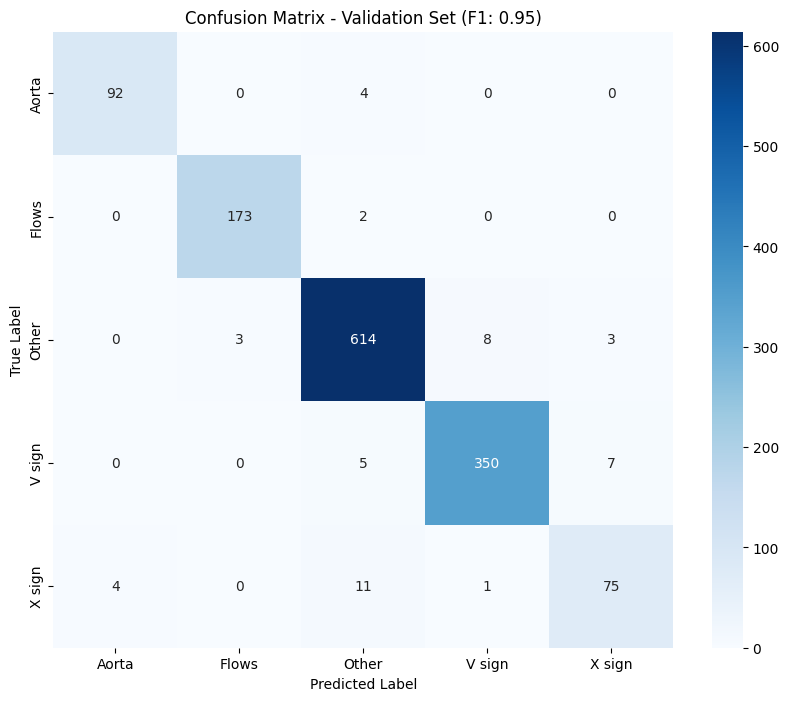


============================== KET QUA TREN TAP TEST ==============================
Classification Report (Test):
              precision    recall  f1-score   support

       Aorta       0.88      0.84      0.86       133
       Flows       1.00      0.97      0.98       219
       Other       0.94      0.96      0.95       689
      V sign       0.97      0.90      0.94       259
      X sign       0.75      0.91      0.82        79

    accuracy                           0.94      1379
   macro avg       0.91      0.92      0.91      1379
weighted avg       0.94      0.94      0.94      1379



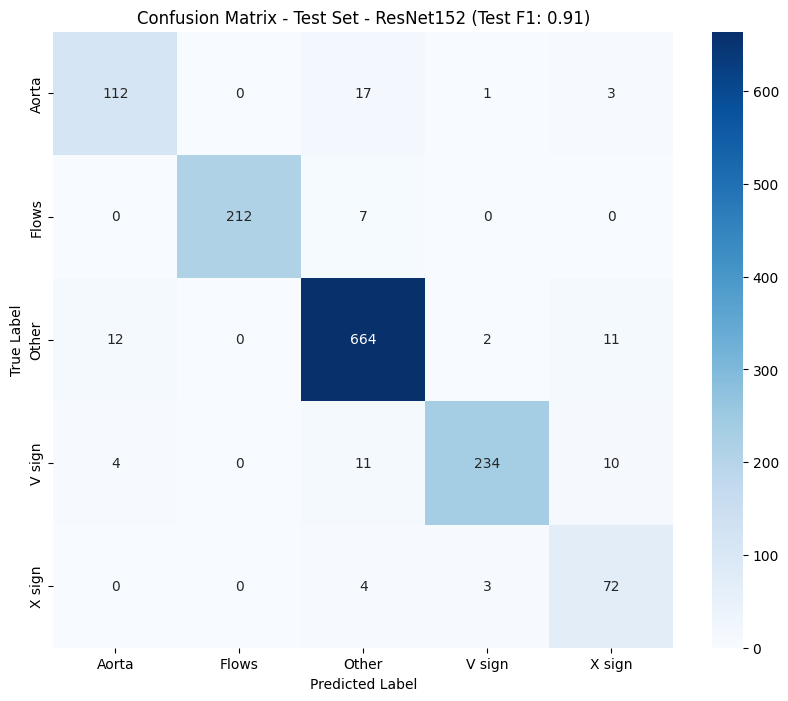

In [11]:
if os.path.exists(pathbestmodel):
    print(f"Dang load weights tot nhat tu: {pathbestmodel}")

    # Khoi tao lai kien truc ResNet152
    model = models.resnet152(num_classes=len(classes))
    model.load_state_dict(torch.load(pathbestmodel, map_location=device))
    model = model.to(device)
    model.eval()

    # ==========================================
    # 1. DANH GIA TREN TAP VALIDATION
    # ==========================================
    y_val_true = []
    y_val_pred = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_val_true.extend(labels.cpu().numpy())
            y_val_pred.extend(predicted.cpu().numpy())

    # Tinh F1 rieng cho Valid de hien thi
    val_f1_score = f1_score(y_val_true, y_val_pred, average='macro')

    print("\n" + "="*30 + " KET QUA TREN TAP VALIDATION " + "="*30)
    print("Classification Report (Validation):")
    print(classification_report(y_val_true, y_val_pred, target_names=classes))

    # Confusion Matrix Validation
    cm_val = confusion_matrix(y_val_true, y_val_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - Validation Set (F1: {val_f1_score:.2f})')
    plt.show()

    # ==========================================
    # 2. DANH GIA TREN TAP TEST
    # ==========================================
    y_test_true = []
    y_test_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_test_true.extend(labels.cpu().numpy())
            y_test_pred.extend(predicted.cpu().numpy())

    # --- QUAN TRONG: Tinh F1 rieng cho Test de hien thi len title ---
    test_f1_score = f1_score(y_test_true, y_test_pred, average='macro')

    print("\n" + "="*30 + " KET QUA TREN TAP TEST " + "="*30)
    print("Classification Report (Test):")
    print(classification_report(y_test_true, y_test_pred, target_names=classes))

    # Confusion Matrix Test
    cm_test = confusion_matrix(y_test_true, y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Hien thi dung F1 cua tap Test
    plt.title(f'Confusion Matrix - Test Set - ResNet152 (Test F1: {test_f1_score:.2f})')
    plt.show()

else:
    print(f"Khong tim thay file model tai: {pathbestmodel}")

In [1]:
!git config --global user.email "khangtruongminh.work@gmail.com"
!git config --global user.name "Khang"

In [2]:
# Thay TOKEN, USERNAME và REPO_NAME
%cd /content
!git clone https://TOKEN@github.com/Thuy25/HocSau.git
%cd HocSau

/content
Cloning into 'HocSau'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 2), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 207.22 KiB | 5.31 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/HocSau


In [3]:
!git checkout -b Khang

Switched to a new branch 'Khang'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')